In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Preparation

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

from scripts.train_isolation_forest import (
    remove_outliers_and_skewness, 
    WaterQualityPipeline,
    convert_to_risk_scores,
    apply_transforms,
    preprocess_features, 
    train_full_isolation_forest, 
    convert_to_risk_scores,
    add_station_encoding,
    load_water_data,
    split_features,
    train_inference_isolation_forest,
    visualize_data_overview,
)


In [23]:
df = load_water_data()
df, label_encoder = add_station_encoding(df)
sensor_features, chemical_features = split_features(df)
all_features = sensor_features + chemical_features

default_station_id = df['station_id'].mode()[0]
default_encoded_value = label_encoder.transform([default_station_id])[0]

print(f"Dataset shape: {df.shape}")
print(f"Sensor features: {sensor_features}")
print(f"Chemical features: {chemical_features}")
print(f"All features: {all_features}")

Dataset shape: (36277, 11)
Sensor features: ['pH', 'TEMP', 'EC', 'station_encoded']
Chemical features: ['NO2N', 'NO3N', 'O2-Dis', 'NH4N']
All features: ['pH', 'TEMP', 'EC', 'station_encoded', 'NO2N', 'NO3N', 'O2-Dis', 'NH4N']


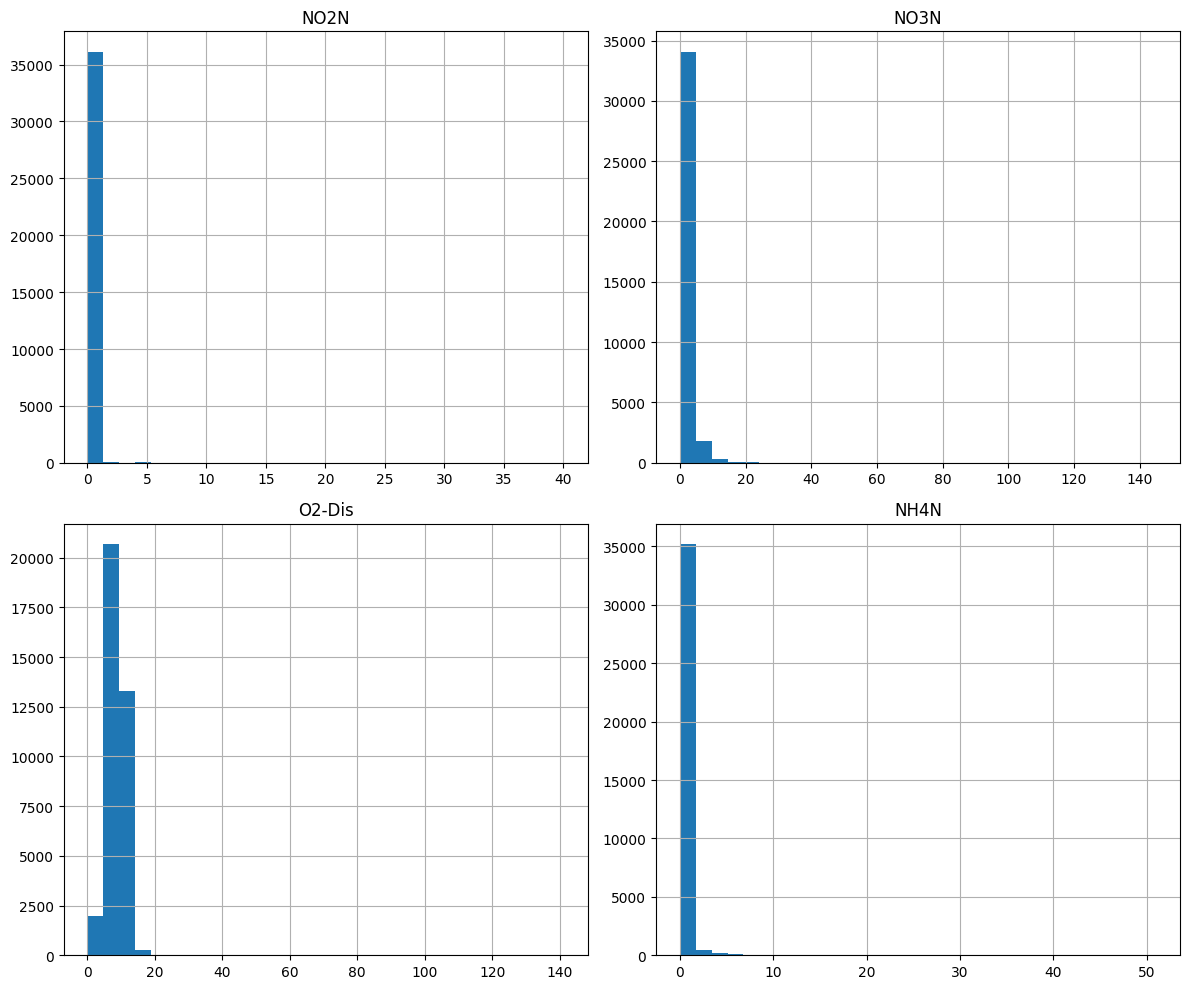

Data types:
GEMS.Station.Number_Sample.Date     object
pH                                 float64
NO2N                               float64
NO3N                               float64
TP                                 float64
O2-Dis                             float64
NH4N                               float64
TEMP                               float64
EC                                 float64
station_id                          object
station_encoded                      int32
dtype: object
Missing values:
GEMS.Station.Number_Sample.Date    0
pH                                 0
NO2N                               0
NO3N                               0
TP                                 0
O2-Dis                             0
NH4N                               0
TEMP                               0
EC                                 0
station_id                         0
station_encoded                    0
dtype: int64


In [24]:

visualize_data_overview(df, sensor_features, chemical_features)
print(f"Data types:\n{df.dtypes}")
print(f"Missing values:\n{df.isnull().sum()}")

### Remove Outliers and Skewness

In [25]:
df_clean, outlier_stats = remove_outliers_and_skewness(df, chemical_features)
print(f"\nAfter outlier removal: {df_clean.shape}")

for features, stats in outlier_stats.items():
    print(f"{features}: Removed {stats['removed']} outliers, skew: {stats['original_skew']:.1f} to {stats['cleaned_skew']:.1f}")

df = apply_transforms(df_clean, chemical_features)
print(f"\nFinal skewness after transformation:")
print(df[chemical_features].skew())


After outlier removal: (23681, 11)
NO2N: Removed 5090 outliers, skew: 51.7 to 2.0
NO3N: Removed 3319 outliers, skew: 16.8 to 1.4
O2-Dis: Removed 533 outliers, skew: 12.6 to 0.0
NH4N: Removed 3654 outliers, skew: 12.2 to 1.2

Final skewness after transformation:
NO2N      3.225578
NO3N      1.623699
O2-Dis   -0.006272
NH4N      1.175232
dtype: float64


### Train Base Model

In [26]:

X_processed, scaler = preprocess_features(df, all_features)
base_model = train_full_isolation_forest(X_processed)
base_anomaly_scores = base_model.decision_function(X_processed)
base_risk_scores = convert_to_risk_scores(base_anomaly_scores)

print(f"High risk samples over>0.5: {(base_risk_scores > 0.5).sum()}")
print(f"Mean risk score: {base_risk_scores.mean():.3f}")

High risk samples over>0.5: 2260
Mean risk score: 0.251


### Train Inference Model

In [27]:
inference_model, inference_scaler = train_inference_isolation_forest(df, sensor_features)
print(f"Model trained on {len(sensor_features)} features: {sensor_features}")

Model trained on 4 features: ['pH', 'TEMP', 'EC', 'station_encoded']


In [28]:
X_sensor_scaled = inference_scaler.transform(df[sensor_features])
inference_anomaly_scores = inference_model.decision_function(X_sensor_scaled)
inference_risk_scores = convert_to_risk_scores(inference_anomaly_scores)
correlation, _ = pearsonr(base_risk_scores, inference_risk_scores)
print(f"Correlation between Full and Inference Models: {correlation:.3f}")

Correlation between Full and Inference Models: 0.688


In [29]:
min_score_fixed = inference_anomaly_scores.min()
max_score_fixed = inference_anomaly_scores.max()

print(f"Calculated fixed score range: min={min_score_fixed:.3f}, max={max_score_fixed:.3f}")

#pipeline with the inference_model, scaler, and fixed scores
final_pipeline = WaterQualityPipeline(
    model=inference_model, 
    scaler=inference_scaler,
    min_score=min_score_fixed,
    max_score=max_score_fixed
)

final_pipeline.save()

loaded_pipeline = WaterQualityPipeline.load()
loaded_pipeline

Calculated fixed score range: min=-0.209, max=0.168
✅ Pipeline saved to ../models/water_quality_pipeline.pkl


### Inference Demo with prebuilt water cases

In [30]:

all_demo_cases = [
    # Original 5 cases
    {
        'name': 'Clean Borehole Water',
        'description': 'A properly maintained borehole with good mineral balance',
        'expected': 'Safe',
        'inputs': {'pH': 7.4, 'TEMP': 21.0, 'EC': 350.0}
    },
    {
        'name': 'Urban River Contamination',
        'description': 'River water downstream from a dense urban area like Ngong town',
        'expected': 'Action Required',
        'inputs': {'pH': 7.9, 'TEMP': 26.0, 'EC': 1800.0}
    },
    {
        'name': 'Rift Valley Mineral Spring',
        'description': 'Geothermal spring with high natural mineral content (fluoride)',
        'expected': 'Action Required',
        'inputs': {'pH': 8.8, 'TEMP': 35.0, 'EC': 2200.0}
    },
    {
        'name': 'High-Altitude Forest Stream',
        'description': 'Cold, fast-flowing stream in a protected forest reserve',
        'expected': 'Safe',
        'inputs': {'pH': 7.1, 'TEMP': 16.0, 'EC': 250.0}
    },
    {
        'name': 'Livestock Watering Hole / Dam',
        'description': 'A community dam with high livestock concentration in Kajiado',
        'expected': 'Action Required',
        'inputs': {'pH': 8.3, 'TEMP': 29.0, 'EC': 1900.0}
    },
    
    # 5 New test cases
    {
        'name': 'Industrial Wastewater Discharge',
        'description': 'Water downstream from textile factory with chemical runoff',
        'expected': 'Action Required',
        'inputs': {'pH': 5.8, 'TEMP': 32.0, 'EC': 2800.0}
    },
    {
        'name': 'Shallow Well in Agricultural Area',
        'description': 'Hand-dug well in area with heavy fertilizer use',
        'expected': 'Action Required',
        'inputs': {'pH': 8.4, 'TEMP': 24.0, 'EC': 1400.0}
    },
    {
        'name': 'Municipal Tap Water',
        'description': 'Treated municipal water supply from Nairobi Water Company',
        'expected': 'Safe',
        'inputs': {'pH': 7.2, 'TEMP': 22.0, 'EC': 420.0}
    },
    {
        'name': 'Acid Mine Drainage',
        'description': 'Water from abandoned copper mine with heavy metal contamination',
        'expected': 'Action Required',
        'inputs': {'pH': 4.2, 'TEMP': 28.0, 'EC': 3500.0}
    },
    {
        'name': 'Bottled Water (Premium)',
        'description': 'Commercial bottled water from a reputable brand',
        'expected': 'Safe',
        'inputs': {'pH': 7.0, 'TEMP': 20.0, 'EC': 180.0}
    }
]

for case in all_demo_cases:
    
    inputs = {
        'pH': case['inputs']['pH'],
        'TEMP': case['inputs']['TEMP'],
        'EC': case['inputs']['EC'],
        "station_encoded": default_encoded_value
    }
    
    risk_score = loaded_pipeline.predict_risk(pd.DataFrame([inputs]))
    print(f"{case['name']}")
    predicted_outcome = "Action Required" if risk_score[0] > 0.5 else "Safe"
    emoji = "✅" if predicted_outcome == case['expected'] else "❌"
    print(f"Expected: {case['expected']} | Predicted: {risk_score[0]:.3f} | Verdict: {emoji}\n")
    print("-" * 50)
    print("\n")
    


Clean Borehole Water
Expected: Safe | Predicted: 0.153 | Verdict: ✅

--------------------------------------------------


Urban River Contamination
Expected: Action Required | Predicted: 0.416 | Verdict: ❌

--------------------------------------------------


Rift Valley Mineral Spring
Expected: Action Required | Predicted: 0.642 | Verdict: ✅

--------------------------------------------------


High-Altitude Forest Stream
Expected: Safe | Predicted: 0.205 | Verdict: ✅

--------------------------------------------------


Livestock Watering Hole / Dam
Expected: Action Required | Predicted: 0.404 | Verdict: ❌

--------------------------------------------------


Industrial Wastewater Discharge
Expected: Action Required | Predicted: 0.794 | Verdict: ✅

--------------------------------------------------


Shallow Well in Agricultural Area
Expected: Action Required | Predicted: 0.271 | Verdict: ❌

--------------------------------------------------


Municipal Tap Water
Expected: Safe | Pre